# RNN Exercises
For these exercises we're using data from the Federal Reserve Economic Database (FRED) concerning Electricity and Gas Utilities Production from January 1992 to January 2019 (325 records).

Data source: https://fred.stlouisfed.org/series/IPG2211A2N

In the exercises below you'll be asked to do the following:
* Perform standard imports, load & plot the dataset (code provided)
* Prepare data for an LSTM model
* Define the LSTM model, loss and optimization functions
* Train the model
* Evaluate the model on test data
* OPTIONAL: Plot the results

<div class="alert alert-danger" style="margin: 10px"><strong>IMPORTANT NOTE!</strong> Make sure you don't run the cells directly above the example output shown, <br>otherwise you will end up writing over the example output!</div>

## Perform standard imports, load and plot the dataset
Run the cells below to load the libraries needed for this exercise and the Energy Production dataset, and to plot the data.

In [1]:
# RUN THIS CELL
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
df = pd.read_csv('../Data/Energy_Production.csv',index_col=0,parse_dates=True)
df.dropna(inplace=True)
print(len(df))
df.head(14)

977


,IPG2211A2N
DATE,
1939-01-01,3.3842
1939-02-01,3.4100
1939-03-01,3.4875
1939-04-01,3.5133
1939-05-01,3.5133
1939-06-01,3.5650
1939-07-01,3.5650
1939-08-01,3.6167
1939-09-01,3.7200


In [3]:
df.tail(12)

,IPG2211A2N
DATE,
2019-06-01,98.4548
2019-07-01,113.0791
2019-08-01,111.2697
2019-09-01,102.0185
2019-10-01,93.9518
2019-11-01,102.1902
2019-12-01,113.0698
2020-01-01,116.0371
2020-02-01,109.6575


In [4]:
df = df.iloc[:-5]
df.tail()

,IPG2211A2N
DATE,
2019-08-01,111.2697
2019-09-01,102.0185
2019-10-01,93.9518
2019-11-01,102.1902
2019-12-01,113.0698


In [37]:
len(df)

972

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 972 entries, 1939-01-01 to 2019-12-01
Data columns (total 1 columns):
IPG2211A2N    972 non-null float64
dtypes: float64(1)
memory usage: 15.2 KB


No null values

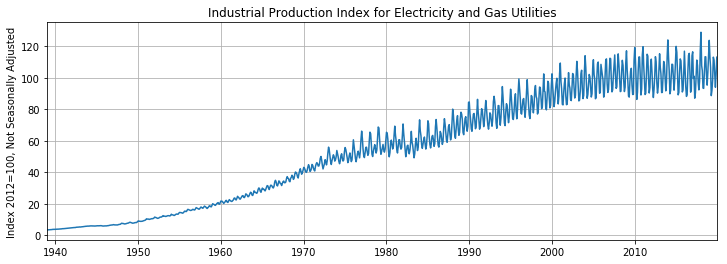

In [6]:
# RUN THIS CELL
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.show()

# Prepare the data
For the first set of exercises we'll
* divide the data into train and test sets
* normalize the training set
* prepare windowed seq/label tuples for an LSTM model

## 1. Divide the data into train and test sets
Working with a window_size of 12, divide the dataset into a sequence of 313 training records (including the window), and a test set of 12 records.

In [7]:
# CODE HERE
y = df['IPG2211A2N'].values.astype(float)

test_size = 12
window_size = 12

train_set = y[:-test_size]
test_set = y[-test_size:]

In [8]:
# Run the code below to check your results:
print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

Train: 960
Test:  12


## 2. Normalize the training set
Feature scale the training set to fit within the range [-1,1].

In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1))

train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [10]:
# Run the code below to check your results:
print(f'First item, original: {train_set[0]}')
print(f'First item, scaled:  {train_norm[0]}')

First item, original: 3.3842
First item, scaled:  [-1.]


## 3. Prepare data for LSTM
Prepare the list of windowed sequence/label tuples to be fed into an LSTM model.

In [11]:
# RUN THIS CELL
train_norm = torch.FloatTensor(train_norm).view(-1)

def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [12]:
# CODE HERE

train_data = input_data(seq=train_norm, ws=window_size)

In [13]:
# Run the code below to check your results:
print(f'Train_data: {len(train_data)}')  # should equal 301

Train_data: 948


## 4. Define the model
Design a model that has a (1,100) LSTM layer and a (100,1) fully-connected linear layer. Be sure to initialize $h_0$ and $c_0$, and return only the last predicted value.

I picked 100 neurons instead of suggested 64 because I have a lot more data than the version of dataset used in the excercise

In [14]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        
        # seq.view(len(seq), 1, -1) is the input
        # It's an array of 12 items since window size is 12
        # The .view is to reshape the input so it lines up correctly going into the LSTM model
        # self.hidden is the tuple (h_0, c_0)
        # lstm_out is the output that'll be fed to the linear layer
        # self.hidden is an updated tuple holding (h_n, c_n) where h_n, c_n are calculated values. Check notebook 81 for formula
        
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        
        # Here just feed the lstm_out (array of size 100) to get prediction for the prediction
        # pred will be a tensor of size 12
        # Reshape lstm_out before passing to linear layer 
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only care about the last prediction, which is the 13th value for the previous 12 data

In [15]:
# Run the code below to check your results:
torch.manual_seed(101)
model = LSTMnetwork()
model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

## 5. Define loss and optimization functions
Define a loss function called "criterion" and an optimizer called "optimizer".<br>
You can use any functions you want, although we used MSELoss and Adam (learning rate of 0.001) respectively.

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### 6. Train the model
Don't worry about tracking loss values, displaying results, or validating the test set. Just train the model through 50 epochs. We'll evaluate the trained model in the next step.<br>
OPTIONAL: print something after each epoch to indicate training progress.

In [17]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    

    # tuple-unpack the train_data set
    # Seq is 12 y-values from train_data
    # y_train is the 13th value
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.01302989
Epoch:  2 Loss: 0.01209039
Epoch:  3 Loss: 0.00287930
Epoch:  4 Loss: 0.00028396
Epoch:  5 Loss: 0.00010779
Epoch:  6 Loss: 0.00022384
Epoch:  7 Loss: 0.00028572
Epoch:  8 Loss: 0.00018801
Epoch:  9 Loss: 0.00001561
Epoch: 10 Loss: 0.00001920
Epoch: 11 Loss: 0.00006388
Epoch: 12 Loss: 0.00013641
Epoch: 13 Loss: 0.00012190
Epoch: 14 Loss: 0.00015379
Epoch: 15 Loss: 0.00018206
Epoch: 16 Loss: 0.00025838
Epoch: 17 Loss: 0.00036798
Epoch: 18 Loss: 0.00055872
Epoch: 19 Loss: 0.00067080
Epoch: 20 Loss: 0.00082580
Epoch: 21 Loss: 0.00091989
Epoch: 22 Loss: 0.00104358
Epoch: 23 Loss: 0.00116962
Epoch: 24 Loss: 0.00132400
Epoch: 25 Loss: 0.00150546
Epoch: 26 Loss: 0.00179955
Epoch: 27 Loss: 0.00203295
Epoch: 28 Loss: 0.00234284
Epoch: 29 Loss: 0.00255682
Epoch: 30 Loss: 0.00250096
Epoch: 31 Loss: 0.00234718
Epoch: 32 Loss: 0.00223648
Epoch: 33 Loss: 0.00201802
Epoch: 34 Loss: 0.00205274
Epoch: 35 Loss: 0.00204218
Epoch: 36 Loss: 0.00223144
Epoch: 37 Loss: 0.00243767
E

### 7. Evaluate the model using the test set
Be sure to re-initialize the hidden parameters $h_0$ and $c_0$ before running the model.

In [18]:
future = 12

# Add the last window of training values to the list of predictions
# From there we predict the 13th value so let's say
# last window of training set: [100-112], predict 113th value
# next window: [101-113], predict 114th value and so on....

preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [35]:
train_norm[-window_size:]

tensor([1.0000, 0.6616, 0.6123, 0.4350, 0.4317, 0.5921, 0.7516, 0.7509, 0.5644,
        0.4648, 0.5964, 0.7457])

In [39]:
preds[:12]

[1.0,
 0.6616394519805908,
 0.6122540235519409,
 0.4350353479385376,
 0.43171167373657227,
 0.592125415802002,
 0.751610279083252,
 0.7509410381317139,
 0.5643583536148071,
 0.4648498296737671,
 0.5963748693466187,
 0.7457467913627625]

In [36]:
train_norm

tensor([-1.0000e+00, -9.9959e-01, -9.9835e-01, -9.9794e-01, -9.9794e-01,
        -9.9712e-01, -9.9712e-01, -9.9630e-01, -9.9465e-01, -9.9465e-01,
        -9.9424e-01, -9.9424e-01, -9.9383e-01, -9.9300e-01, -9.9259e-01,
        -9.9259e-01, -9.9218e-01, -9.9136e-01, -9.9136e-01, -9.9053e-01,
        -9.8971e-01, -9.8930e-01, -9.8765e-01, -9.8765e-01, -9.8724e-01,
        -9.8642e-01, -9.8559e-01, -9.8477e-01, -9.8436e-01, -9.8312e-01,
        -9.8230e-01, -9.8148e-01, -9.8107e-01, -9.8066e-01, -9.7983e-01,
        -9.7819e-01, -9.7736e-01, -9.7654e-01, -9.7613e-01, -9.7613e-01,
        -9.7613e-01, -9.7571e-01, -9.7324e-01, -9.7283e-01, -9.7242e-01,
        -9.7242e-01, -9.7119e-01, -9.6995e-01, -9.7078e-01, -9.6954e-01,
        -9.6913e-01, -9.6789e-01, -9.6748e-01, -9.6584e-01, -9.6501e-01,
        -9.6460e-01, -9.6295e-01, -9.6295e-01, -9.6172e-01, -9.6172e-01,
        -9.6254e-01, -9.6131e-01, -9.5966e-01, -9.5925e-01, -9.5925e-01,
        -9.5925e-01, -9.6007e-01, -9.5966e-01, -9.6

In [19]:
# Display predicted values
preds[window_size:]    # equivalent to preds[-future:]

[0.8498290181159973,
 0.5951324701309204,
 0.48485666513442993,
 0.4895767569541931,
 0.607872724533081,
 0.7684909105300903,
 0.6623377799987793,
 0.5329124927520752,
 0.38662123680114746,
 0.4716174602508545,
 0.6738612651824951,
 0.8038812279701233]

## 8. Inverse transform the predicted values
Rescale the predicted values up to the original test set range.

In [20]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[119.48215143],
       [103.49702677],
       [ 96.57595735],
       [ 96.87219715],
       [104.29662361],
       [114.37725386],
       [107.71492946],
       [ 99.59201077],
       [ 90.41055942],
       [ 95.74504565],
       [108.4381601 ],
       [116.5984015 ]])

## BONUS EXERCISE: Plot the result
Plot the true_predictions values together with the original data. Remember to create a range of datetime values for the predicted data.

In [21]:
df.tail(12)

,IPG2211A2N
DATE,
2019-01-01,123.7687
2019-02-01,112.9837
2019-03-01,106.6593
2019-04-01,88.6631
2019-05-01,91.9852
2019-06-01,98.4548
2019-07-01,113.0791
2019-08-01,111.2697
2019-09-01,102.0185


In [31]:
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
       '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
       '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01'],
      dtype='datetime64[D]')

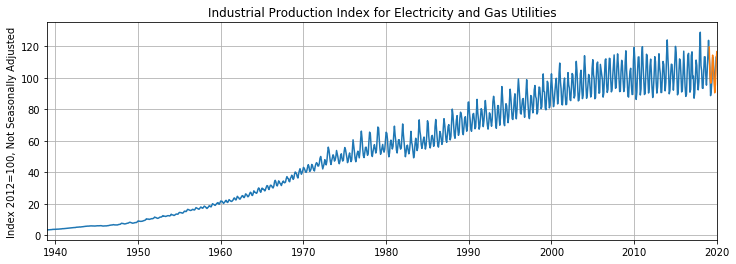

In [32]:
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(x,true_predictions)
plt.show()

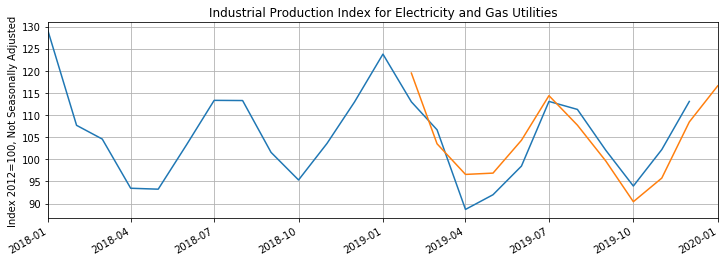

In [40]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['IPG2211A2N']['2018-01-01':])
plt.plot(x,true_predictions)
plt.show()